# Analysis of RMSD change between generated and minimised structures

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
from rdkit import Chem
import rdkit.Chem.PandasTools as PandasTools

PandasTools.InstallPandasTools()

In [4]:
import os

### Analysis Variables

In [5]:
blob = "lig_gen"

Maximum RMSD threshold used for filtering molecules with low RMSD between generated and minimised structure:

In [6]:
maxRMSD = 1.0

Minimum QED threshold used for filtering:

In [7]:
minQED = 0.7

### Helper Functions

TODO: Extract such functions in a Python module.

In [8]:
def root_and_prefix(datafile):
    """
    Root directory and prefix.
    """
    dataroot = os.path.dirname(datafile)
    prefix, _ = os.path.splitext(os.path.basename(datafile))

    return dataroot, prefix

In [9]:
def load_rmsd(dataroot, prefix, df):
    """
    Load ligand RMSD CSV files and add RMSD to DataFrame
    """
    ligands = df["lig_name"].unique()

    # Load RMSDs
    for ligand in ligands:
        fname = os.path.join(dataroot, prefix + "_" + ligand + f"_{blob}_RMSDmin.csv")
        df_rmsd = pd.read_csv(fname)

        # Assign ligand RMSD to general dataset
        # Assumes sample indices are in the same order (but indices might be missing from RMSD dataframe)
        df.loc[
            (df["sample_idx"].isin(df_rmsd["sample"])) & (df["lig_name"] == ligand),
            "rmsd",
        ] = df_rmsd["rmsd"].to_numpy()

    # Drop all samples for which the RMSD between generated and minimised structures
    # could not be computed (reconstruction failed):
    nall = len(df)
    df.dropna(subset=["rmsd"], inplace=True)

    print(f"Successfully reconstructed molecules: {len(df) / nall * 100:.2f}%")

In [10]:
def rmsd_statistics(df, mRMSD):
    rmsd = df["rmsd"].to_numpy()

    print(f"Average RMSD: {np.mean(rmsd)}")
    print(f"Median RMSD: {np.median(rmsd)}")
    print(
        f"Percentage of low-RMSD samples: {np.logical_and(rmsd < mRMSD, rmsd > 0.05).sum() / len(rmsd)  * 100}%"
    )
    # print(f"Percentage of unique molecules: {len(df[f'{blob}_fit_add_SMILES'].unique()) / nall * 100}%")

In [11]:
def filter(df, mRMSD, mQED):
    # Some systems have 0.0 RMSD
    df_lowrmsd = df[(df.rmsd < mRMSD) & (df.rmsd > 0.05)].copy()

    # Sort by RMSD, so that fropping duplicates will retain lowest RMSD
    df_lowrmsd.sort_values(by="rmsd", ascending=True, inplace=True)
    df_lowrmsd = df_lowrmsd.drop_duplicates(
        subset=[f"{blob}_fit_add_SMILES"], keep="first"
    )

    # Add RDKit molecule
    PandasTools.AddMoleculeColumnToFrame(
        df_lowrmsd, f"{blob}_fit_add_SMILES", f"mol_{blob}"
    )

    return df_lowrmsd[df_lowrmsd[f"{blob}_fit_add_QED"] > mQED]

## Variability Factor 0.5

### Data

In [12]:
datafile = "generated/CDK2lig_vf0.5.gen_metrics"

Load generative model metrics (from `*.gen_metrics` file):

In [13]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2lig_vf0.5'

In [14]:
df = pd.read_csv(datafile, sep=" ")
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_min_time,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref
0,4ek4_B_1CK_min,0,29.005375,NaN,28.824574,NaN,45.025047,948.640381,20.182104,NaN,...,NaN,NaN,NaN,NaN,0.000380,6.743496e-07,NaN,NaN,NaN,NaN
1,4ek4_B_1CK_min,1,29.005375,NaN,28.551495,NaN,42.517689,926.354126,20.688665,NaN,...,2766.683457,722.404393,-2044.279064,NaN,0.009074,1.118392e+00,2707.024095,662.745031,NaN,NaN
2,4ek4_B_1CK_min,2,29.005375,NaN,28.868849,NaN,43.761471,962.305664,20.380903,NaN,...,3704.668065,39.021142,-3665.646922,NaN,0.009523,7.645128e-01,3645.008703,-20.638220,NaN,NaN
3,4ek4_B_1CK_min,3,29.005375,NaN,28.417500,NaN,39.385441,919.772217,20.558111,NaN,...,49787.186418,19.228882,-49767.957536,NaN,0.019672,1.410960e+00,49727.527056,-40.430480,NaN,NaN
4,4ek4_B_1CK_min,4,29.005375,NaN,29.240814,NaN,44.442345,954.583618,20.295244,NaN,...,NaN,NaN,NaN,NaN,0.000442,8.529922e-07,NaN,NaN,NaN,NaN


Available metrics:

In [15]:
print([c for c in df.columns])

['lig_name', 'sample_idx', 'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance', 'lig_gen_L2_loss', 'lig_gen_L1_loss', 'lig_latent_norm', 'lig_latent_variance', 'lig_fit_norm', 'lig_fit_variance', 'lig_fit_L2_loss', 'lig_fit_L1_loss', 'lig_gen_fit_norm', 'lig_gen_fit_variance', 'lig_gen_fit_L2_loss', 'lig_gen_fit_L1_loss', 'lig_n_atoms', 'lig_radius', 'lig_fit_n_atoms', 'lig_fit_radius', 'lig_fit_type_diff', 'lig_fit_exact_types', 'lig_fit_RMSD', 'lig_fit_time', 'lig_fit_n_visited', 'lig_est_type_diff', 'lig_est_exact_types', 'lig_gen_fit_n_atoms', 'lig_gen_fit_radius', 'lig_gen_fit_type_diff', 'lig_gen_fit_exact_types', 'lig_gen_fit_RMSD', 'lig_gen_fit_time', 'lig_gen_fit_n_visited', 'lig_gen_est_type_diff', 'lig_gen_est_exact_types', 'lig_n_frags', 'lig_error', 'lig_valid', 'lig_MW', 'lig_logP', 'lig_QED', 'lig_SAS', 'lig_NPS', 'lig_SMILES', 'lig_E', 'lig_min_E', 'lig_dE_min', 'lig_min_error', 'lig_min_time', 'lig_RMSD_min', 'lig_add_n_frags', 'lig_add_error', 'lig_add_vali

Load RMSD calculations (between generated and minimised structures) for each ligand:

In [16]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 89.53%


### Molecules

In [17]:
# Add RDKit molecule
PandasTools.AddMoleculeColumnToFrame(df, f"{blob}_fit_add_SMILES", f"mol_{blob}")

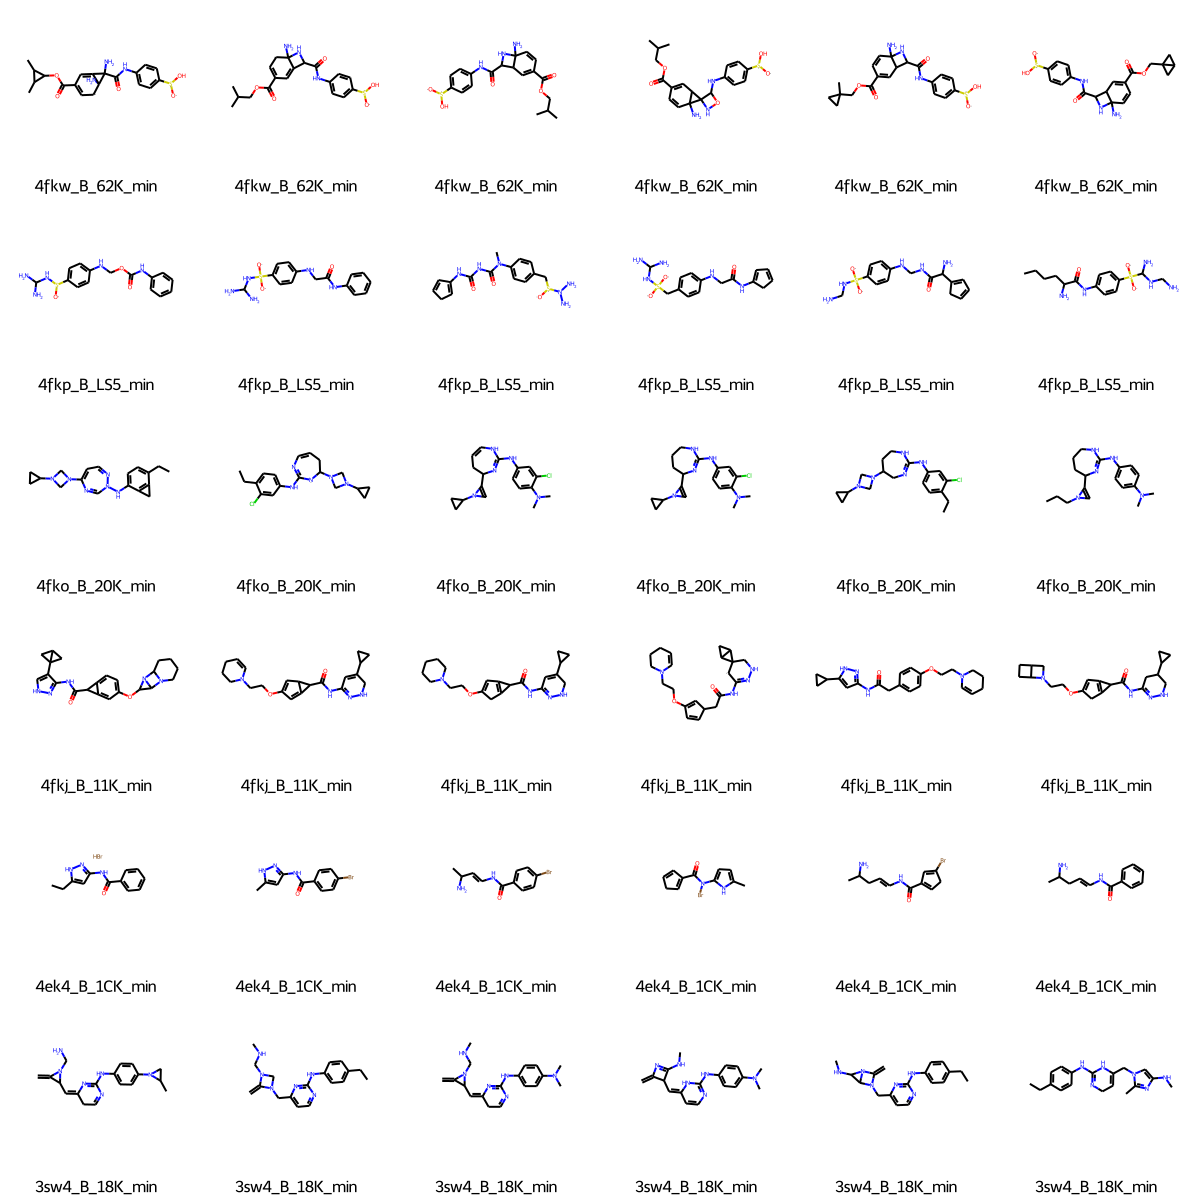

In [18]:
img = PandasTools.FrameToGridImage(
    df.drop_duplicates(subset=f"{blob}_fit_add_SMILES")
    .sort_values(by=["lig_name", f"{blob}_fit_add_QED"], ascending=False)
    .groupby("lig_name")
    .head(6)
    .reset_index(drop=True),
    column=f"mol_{blob}",
    legendsCol=f"lig_name",
    molsPerRow=6,
    maxMols=60,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [19]:
img.save(os.path.join("plots", prefix + "_topQED.png"))

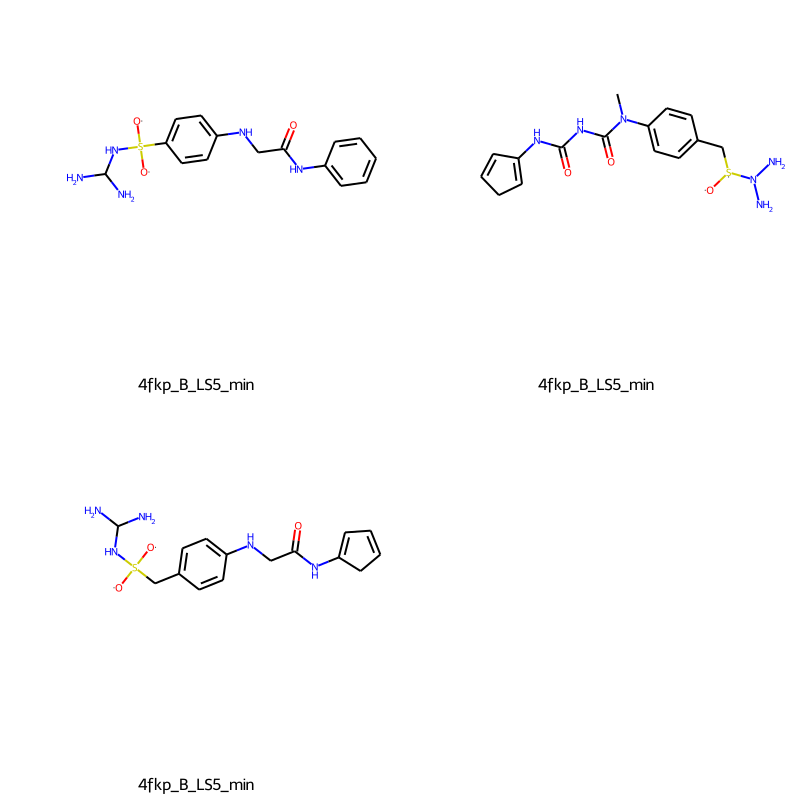

In [20]:
df_plot = (
    df.drop_duplicates(subset=f"{blob}_fit_add_SMILES")
    .sort_values(by=["lig_name", f"{blob}_fit_add_QED"], ascending=False)
    .groupby("lig_name")
    .head(6)
    .reset_index(drop=True)
)
img = PandasTools.FrameToGridImage(
    df_plot.iloc[[7, 8, 9]],
    column=f"mol_{blob}",
    legendsCol=f"lig_name",
    molsPerRow=2,
    maxMols=10,
    subImgSize=(400, 400),
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

### Distributions

#### RMSD

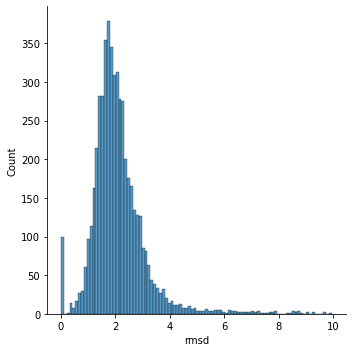

In [21]:
sns.displot(df[df.rmsd < 10]["rmsd"])
plt.savefig(os.path.join("plots", prefix + "_distRMSD.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSD.png"))

Systems with 0.0 RMSD are systems for which the minimisation failed (the generated molecule is not minimied but the minimised output is nonetheless produced). Some failures are due to "Unrecognized charge state for atoms: #X" while other are not better specified `UFF Exception` problems.

#### QED

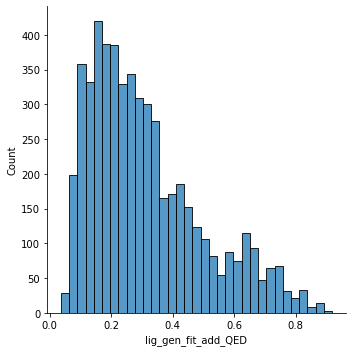

In [22]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

### Simple Statistics

In [23]:
rmsd_statistics(df, maxRMSD)

Average RMSD: 6.963773523827252
Median RMSD: 1.973205
Percentage of low-RMSD samples: 3.7043931496649294%


### Filter Molecules

In [24]:
df_filtered = filter(df, maxRMSD, minQED)

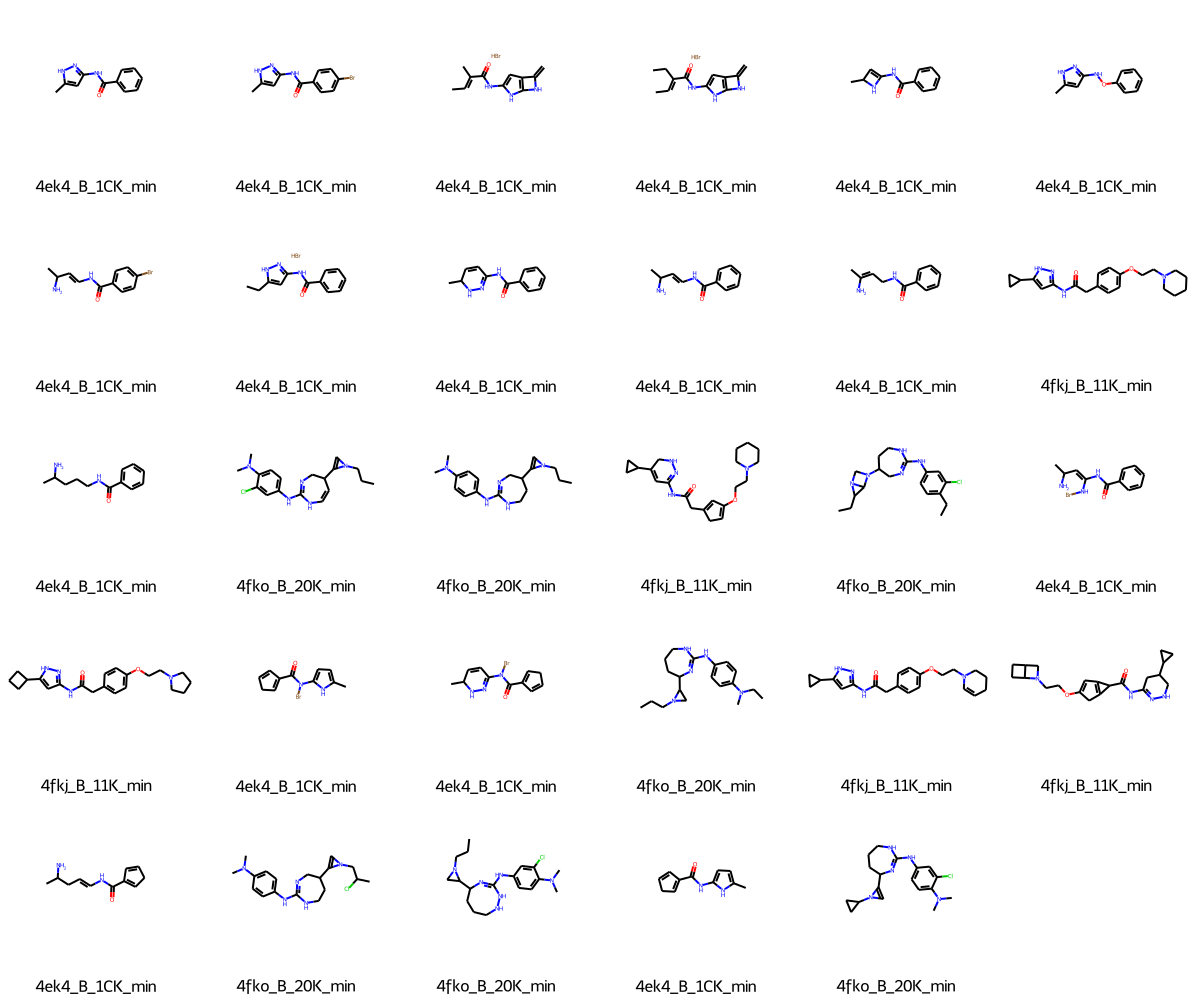

In [25]:
img = PandasTools.FrameToGridImage(
    df_filtered,
    column=f"mol_{blob}",
    legendsCol="lig_name",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [26]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [27]:
len(df_filtered)

29

## Variability Factor: 1.0

### Data

In [28]:
datafile = "generated/CDK2lig_vf1.0.gen_metrics"

In [29]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2lig_vf1.0'

In [30]:
df = pd.read_csv(datafile, sep=" ")
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_min_time,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref
0,4ek4_B_1CK_min,0,29.005375,NaN,29.426668,NaN,30.964363,832.277466,30.357952,NaN,...,15147.690556,691.054877,-14456.635678,NaN,0.025541,1.597036,15088.031194,631.395516,NaN,NaN
1,4ek4_B_1CK_min,1,29.005375,NaN,29.897249,NaN,37.948681,940.969849,29.845579,NaN,...,5210.513023,134.811120,-5075.701903,NaN,0.018131,1.253615,5150.853661,75.151758,NaN,NaN
2,4ek4_B_1CK_min,2,29.005375,NaN,30.889732,NaN,39.811577,919.640381,30.508804,NaN,...,18725.335573,36.179577,-18689.155996,NaN,0.015229,0.826221,18665.676212,-23.479785,NaN,NaN
3,4ek4_B_1CK_min,3,29.005375,NaN,29.745985,NaN,25.817383,814.106384,28.346785,NaN,...,5629.807726,644.009890,-4985.797836,NaN,0.015235,1.092291,5570.148364,584.350528,NaN,NaN
4,4ek4_B_1CK_min,4,29.005375,NaN,31.658167,NaN,35.372356,910.473328,30.521769,NaN,...,124551.116534,750.605203,-123800.511330,NaN,0.021946,2.158922,124491.457172,690.945842,NaN,NaN


Load RMSD calculations (between generated and minimised structures) for each ligand:

In [31]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 90.05%


In [32]:
df[df.rmsd > 10][["lig_name", "sample_idx", "rmsd"]]

,lig_name,sample_idx,rmsd
3085,4fko_B_20K_min,85,17.59275
4013,4fkp_B_LS5_min,13,13.49836
4055,4fkp_B_LS5_min,55,10.11737
4064,4fkp_B_LS5_min,64,15.83760
4070,4fkp_B_LS5_min,70,172.73156
...,...,...,...
5852,4fkw_B_62K_min,852,11.45324
5880,4fkw_B_62K_min,880,11.29869
5888,4fkw_B_62K_min,888,29.29239
5920,4fkw_B_62K_min,920,57.14646


### Distributions

#### RMSD

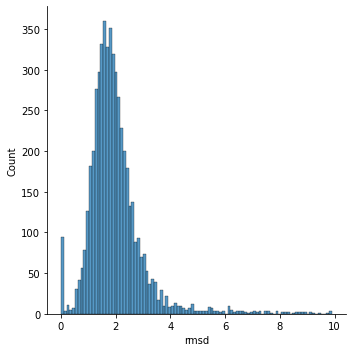

In [33]:
sns.displot(df[df.rmsd < 10]["rmsd"])
plt.savefig(os.path.join("plots", prefix + "_distRMSD.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSD.png"))

#### QED

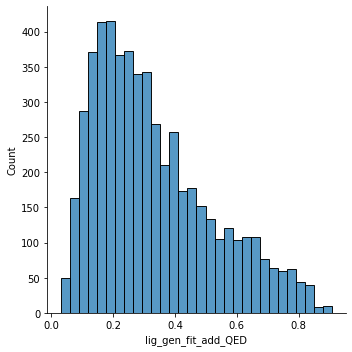

In [34]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

### Simple Statistics

In [35]:
rmsd_statistics(df, maxRMSD)

Average RMSD: 4.137308358319452
Median RMSD: 1.82777
Percentage of low-RMSD samples: 5.700536738848787%


### Filter Molecules

In [36]:
df_filtered = filter(df, maxRMSD, minQED)

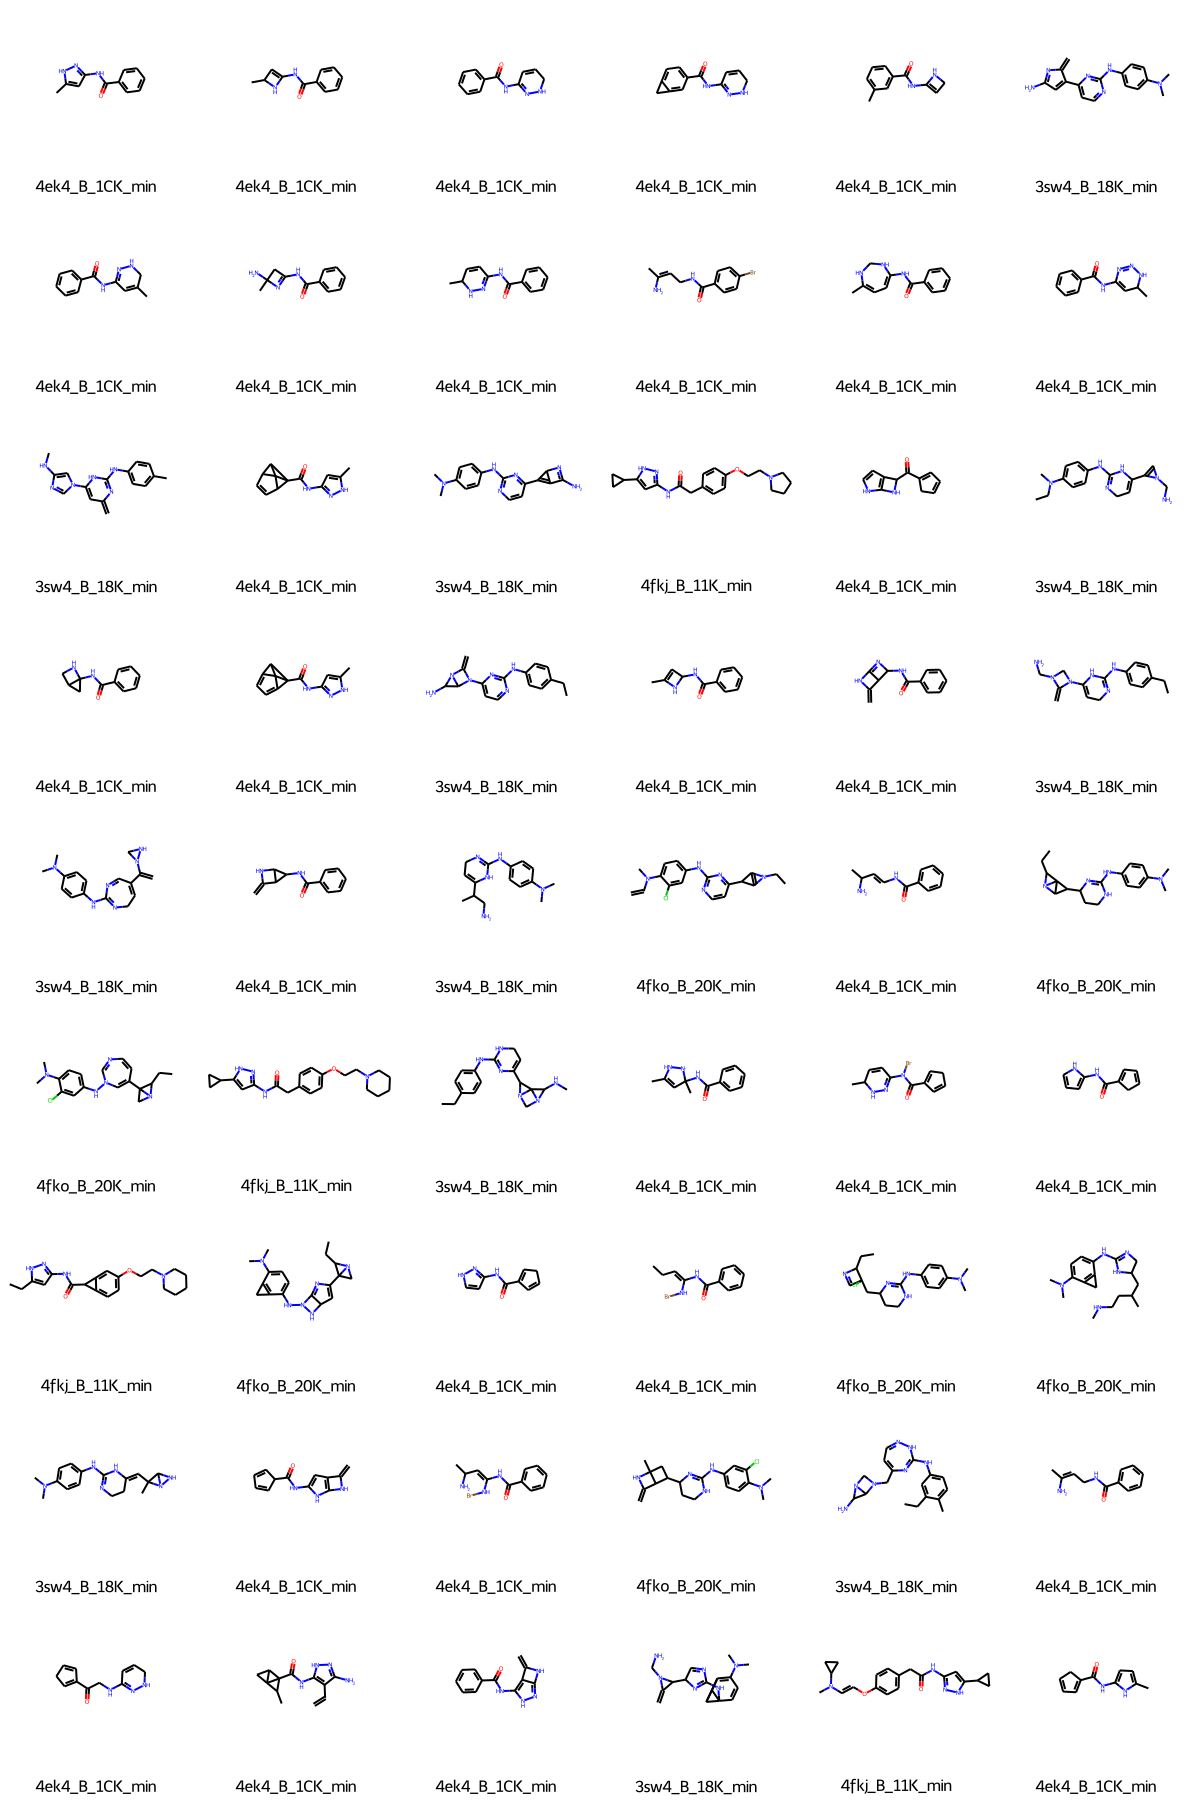

In [37]:
img = PandasTools.FrameToGridImage(
    df_filtered,
    column=f"mol_{blob}",
    legendsCol="lig_name",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [38]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [39]:
len(df_filtered)

54

## Variability Factor: 5.0

### Data

In [40]:
datafile = "generated/CDK2lig_vf5.0.gen_metrics"

In [41]:
dataroot, prefix = root_and_prefix(datafile)
prefix

'CDK2lig_vf5.0'

In [42]:
df = pd.read_csv(datafile, sep=" ")
df.head()

,lig_name,sample_idx,lig_norm,lig_variance,lig_gen_norm,lig_gen_variance,lig_gen_L2_loss,lig_gen_L1_loss,lig_latent_norm,lig_latent_variance,...,lig_gen_fit_add_E,lig_gen_fit_add_min_E,lig_gen_fit_add_dE_min,lig_gen_fit_add_min_error,lig_gen_fit_add_min_time,lig_gen_fit_add_RMSD_min,lig_gen_fit_add_dE_ref,lig_gen_fit_add_min_dE_ref,lig_gen_fit_add_RMSD_ref,lig_gen_fit_add_min_RMSD_ref
0,4ek4_B_1CK_min,0,29.005375,NaN,37.227772,NaN,788.736633,4282.995117,129.618652,NaN,...,2.384705e+08,375.314033,-2.384701e+08,NaN,0.044949,2.364769,2.384704e+08,315.654671,NaN,NaN
1,4ek4_B_1CK_min,1,29.005375,NaN,36.307053,NaN,743.422546,4447.357422,132.967743,NaN,...,9.015647e+07,446.913767,-9.015602e+07,NaN,0.056183,2.148781,9.015641e+07,387.254406,NaN,NaN
2,4ek4_B_1CK_min,2,29.005375,NaN,33.360989,NaN,589.923584,3947.869385,131.208984,NaN,...,3.554753e+05,369.841630,-3.551055e+05,NaN,0.101077,1.906871,3.554157e+05,310.182268,NaN,NaN
3,4ek4_B_1CK_min,3,29.005375,NaN,38.791779,NaN,742.547302,4433.086914,127.115829,NaN,...,2.473512e+08,906.869511,-2.473503e+08,NaN,0.119575,2.117780,2.473512e+08,847.210149,NaN,NaN
4,4ek4_B_1CK_min,4,29.005375,NaN,39.019382,NaN,743.069824,4096.906250,130.029709,NaN,...,6.043773e+08,369.071868,-6.043770e+08,NaN,0.070926,2.417671,6.043773e+08,309.412506,NaN,NaN


Load RMSD calculations (between generated and minimised structures) for each ligand:

In [43]:
load_rmsd(dataroot, prefix, df)

Successfully reconstructed molecules: 94.68%


In [44]:
df[df.rmsd > 10][["lig_name", "sample_idx", "rmsd"]]

,lig_name,sample_idx,rmsd
1089,4fkj_B_11K_min,89,26.46215
1363,4fkj_B_11K_min,363,45.87568
1505,4fkj_B_11K_min,505,27.76480
1867,4fkj_B_11K_min,867,22.63600


Remove system with RMSD higer than 10:

In [45]:
df.drop(df[df.rmsd > 10].index, inplace=True)

### Distributions

#### RMSD

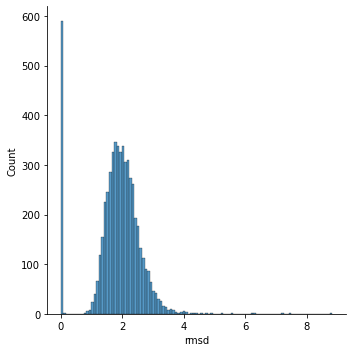

In [46]:
sns.displot(df["rmsd"])
plt.savefig(os.path.join("plots", prefix + "_distRMSD.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distRMSD.png"))

#### QED

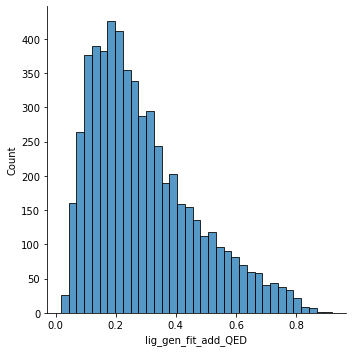

In [47]:
sns.displot(df[f"{blob}_fit_add_QED"])
plt.savefig(os.path.join("plots", prefix + "_distQED.pdf"))
plt.savefig(os.path.join("plots", prefix + "_distQED.png"))

### Simple Statistics

In [48]:
rmsd_statistics(df, maxRMSD)

Average RMSD: 1.8269202836004934
Median RMSD: 1.91357
Percentage of low-RMSD samples: 0.31706887440549586%


### Filter Molecules

In [49]:
df_filtered = filter(df, maxRMSD, minQED)

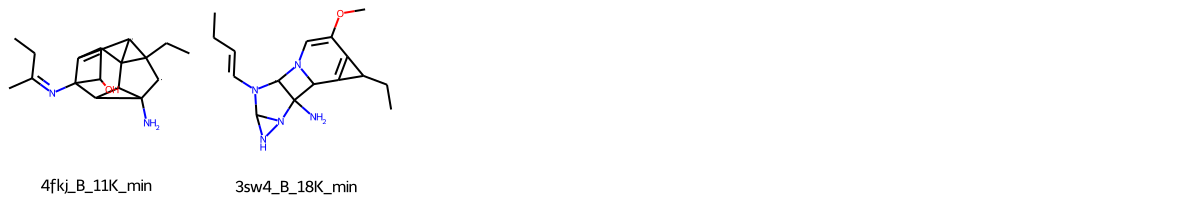

In [50]:
img = PandasTools.FrameToGridImage(
    df_filtered,
    column=f"mol_{blob}",
    legendsCol="lig_name",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img

In [51]:
img.save(os.path.join("plots", prefix + "_molfiltered.png"))

In [52]:
len(df_filtered)

2

### All Molecules

In [53]:
# Add RDKit molecule
PandasTools.AddMoleculeColumnToFrame(df, f"{blob}_fit_add_SMILES", f"mol_{blob}")

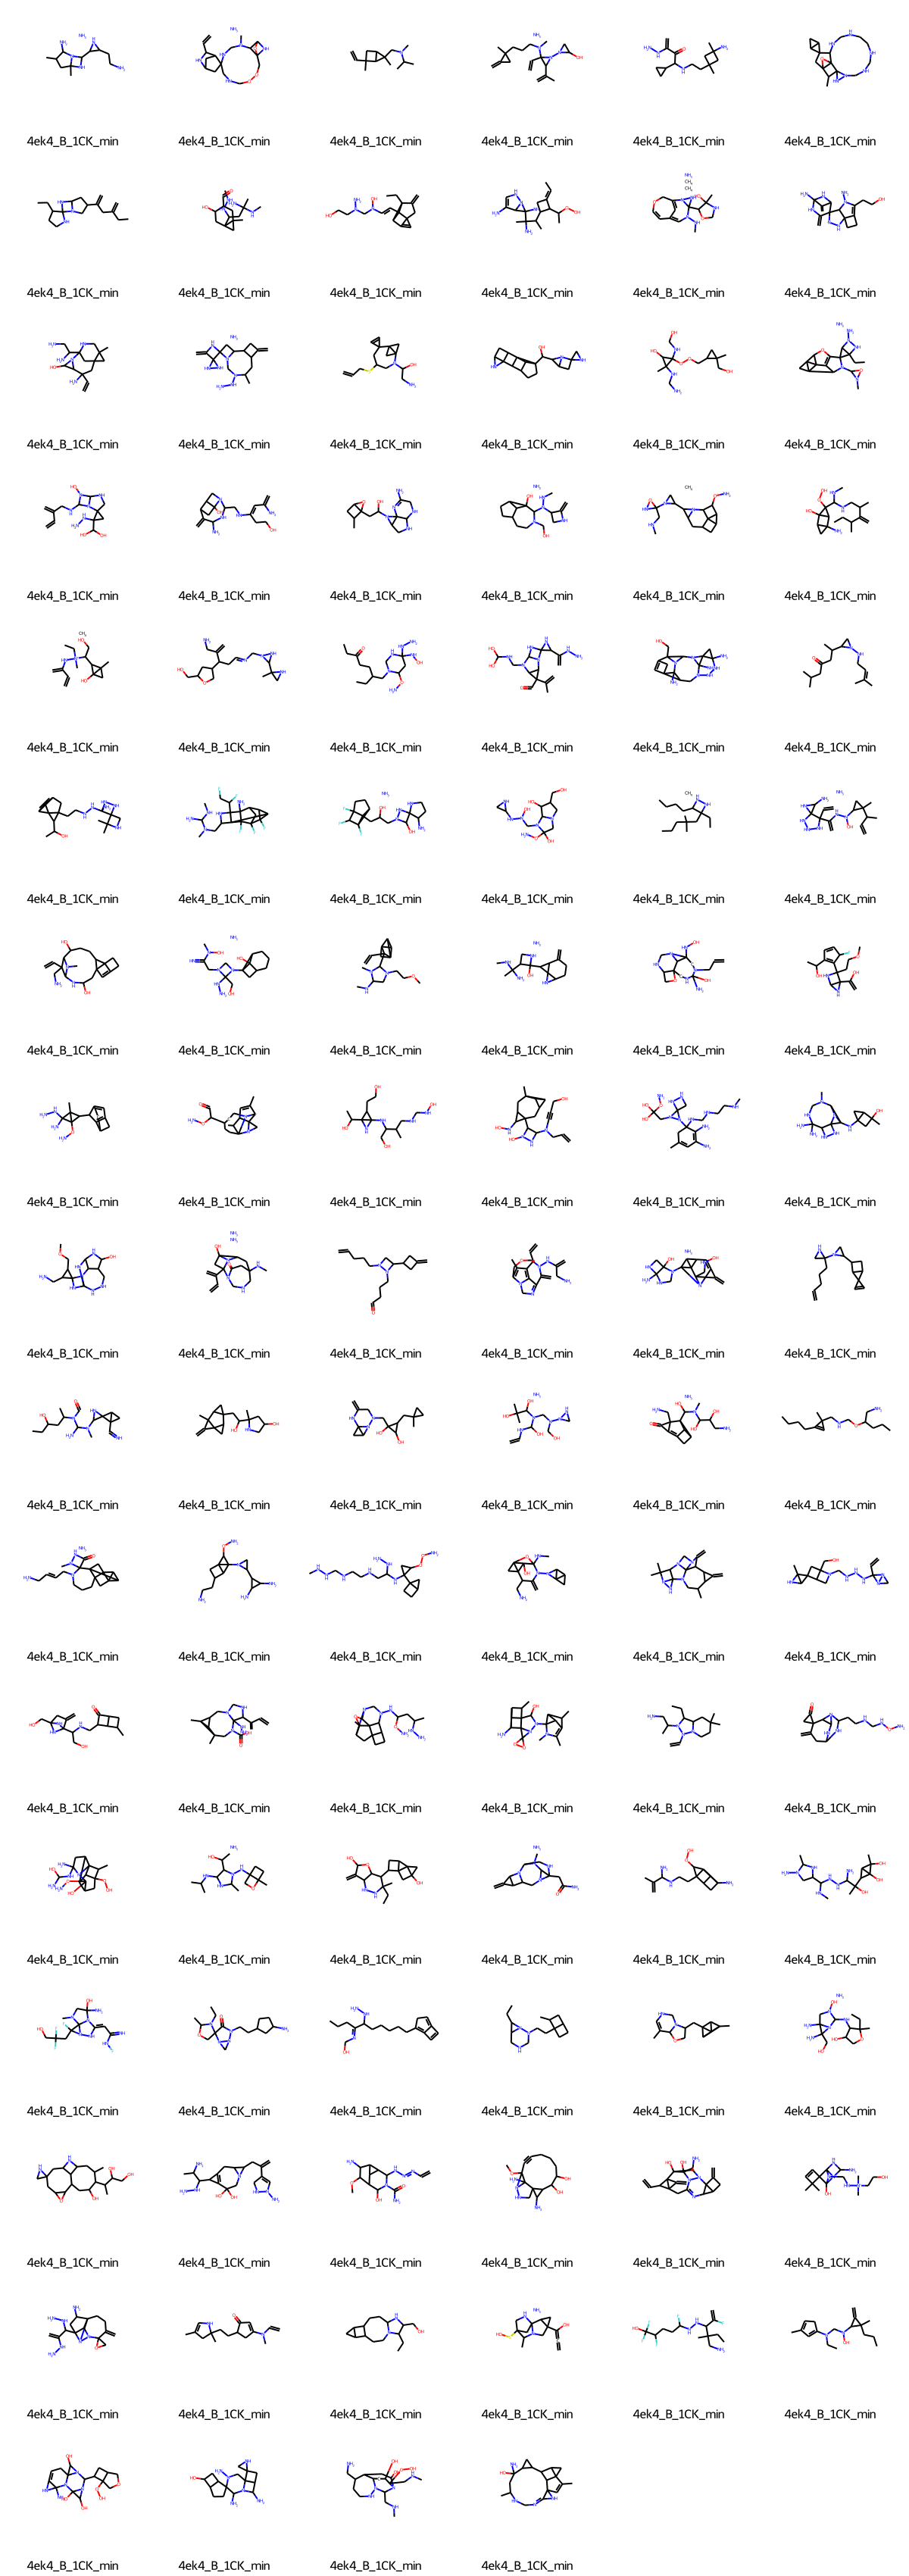

In [54]:
img = PandasTools.FrameToGridImage(
    df.iloc[0:100],
    column=f"mol_{blob}",
    legendsCol="lig_name",
    molsPerRow=6,
    maxMols=np.inf,
    returnPNG=False,  # https://stackoverflow.com/questions/65470233/attributeerror-image-object-has-no-attribute-save
)
img